# Control of a "spacecraft" platform with a reaction wheel

Do all imports:

In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Dec 10 2021 09:55:58


This function returns the solution to the LQR problem

$$\begin{align*} \underset{u_{[t_0,\infty]}}{\text{minimize}} &\qquad\int_{t_0}^{\infty} \left( x(t)^T Q x(t) + u(t)^T R u(t) \right) dt\\ \text{subject to} &\qquad\dot{x}(t)=Ax(t)+Bu(t) \\ &\qquad x(t_0)=x_0. \end{align*}$$

In [2]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K, P

Given a choice of ground roll angle $\phi$, the equations of motion are

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

where

* $q_1$ is the platform angle
* $\dot{q}_1$ is the platform velocity
* $v_2$ is the wheel velocity
* $\tau$ is the torque applied *to* the platform *by* the wheel

and

$$
J_1 = J_p + m_wl^2
\qquad
\qquad
J_2 = J_w
$$

and parameter values are defined as follows:

In [3]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [4]:
simulator = ae353_platform.Simulator(
    display=True,
    roll=0.,
)

# Control wheel velocity only (no gravity)

Set ground roll angle of simulator.

In [5]:
simulator.set_roll(0.)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=0$, ignore platform) are:

$$
\begin{aligned}
J_1 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

Define a function to return a state-space model for a given choice of equilibrium point.

In [6]:
def get_model(v2e, taue):
    # Define variables
    v2, tau = sym.symbols('v2, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        - ((J1 + J2) / (J1 * J2)) * tau,
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([v2, tau], f)
    if not np.allclose(f_num(v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([v2])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([v2, tau], A_sym)
    B_num = sym.lambdify([v2, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(v2e, taue).astype(float)
    B = B_num(v2e, taue).astype(float)

    # Return A and B
    return A, B

Define functions for implementation and analysis.

In [7]:
# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, v2e, taue):
        self.K = K
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, v2e, taue, K, v2i, max_time=5.0):
    # Create controller
    controller = Controller(K, v2e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=0.,
        platform_velocity=0.,
        wheel_angle=0.,
        wheel_velocity=v2i,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['wheel_velocity'][0] - v2e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x
    
# Define a function to show results.
def show_results(data, v2e, taue, A, B, K, v2i, show_pred=False):
    t = data['t']
    v2 = data['wheel_velocity']
    tau = - data['wheel_torque']
    x1 = v2 - v2e
    
    fig, (ax_v2, ax_tau) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    ax_v2.plot(t, v2, label=r'$v_2$', linewidth=4)
    ax_v2.plot(t, np.ones_like(t) * v2e, '--', label=r'$v_2$ (desired)', linewidth=4)
    
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
    ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, v2e, A, B)
        x1_num = x_num[:, 0]
        
        # Get u(t)
        u_num = - (K @ x_num.T).T
        u1_num = u_num[:, 0]
        
        # Compute v2(t) from x(t)
        v2_num = x1_num + v2e
        
        # Compute tau(t) from u(t)
        tau_num = u1_num + taue
        
        # Add everything to plots
        ax_v2.plot(t, v2_num, ':', label=r'$v_2$ (linear)', linewidth=6, color='C3')
        ax_tau.plot(t, tau_num, ':', label=r'$\tau$ (linear)', linewidth=6, color='C3')
        
    ax_v2.grid()
    ax_v2.legend(fontsize=16)
    ax_v2.tick_params(labelsize=14)
    ax_v2.set_ylim(-2*np.pi, 4*np.pi)
    
    ax_tau.grid()
    ax_tau.legend(fontsize=16)
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)
        
    ax_tau.set_xlabel('time (s)', fontsize=20)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Choose equilibrium point and get state-space model.

In [8]:
# Choose equilibrium point
(v2e, taue) = (2*np.pi, 0.)

# Get state-space model
A, B = get_model(v2e, taue)

# Show state-space model
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[0.]]

B =
[[-33.]]


Check if system is controllable.

In [9]:
# Find controllability matrix
W = np.block([B])

# Check size of controllability matrix
print(f'shape of W is {W.shape}\n')

# Find determinant of controllability matrix
print(f'det(W) = {linalg.det(W)}\n')

# Find rank of controllability matrix
print(f'rank(W) = {np.linalg.matrix_rank(W)}')
print(f'number of states is {A.shape[0]}')

shape of W is (1, 1)

det(W) = -33.0

rank(W) = 1
number of states is 1


Do control design by eigenvalue placement.

In [10]:
# Choose desired eigenvalue locations
p = [-1.]

# Find gain matrix to put eigenvalues at desired locations
K = signal.place_poles(A, B, p).gain_matrix

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

K =
[[-0.03030303]]

p = [-1.+0.j]


Do control design by LQR.

In [11]:
# Choose weights
# Q = np.eye(1)
Q = np.diag([1.])
R = np.diag([1.])


# Find optimal gain matrix (and cost matrix)
K, P = lqr(A, B, Q, R)

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

K =
[[-1.]]

p = [-33.+0.j]


Show results for particular choices of equilibrium point, gain matrix, and initial conditions.

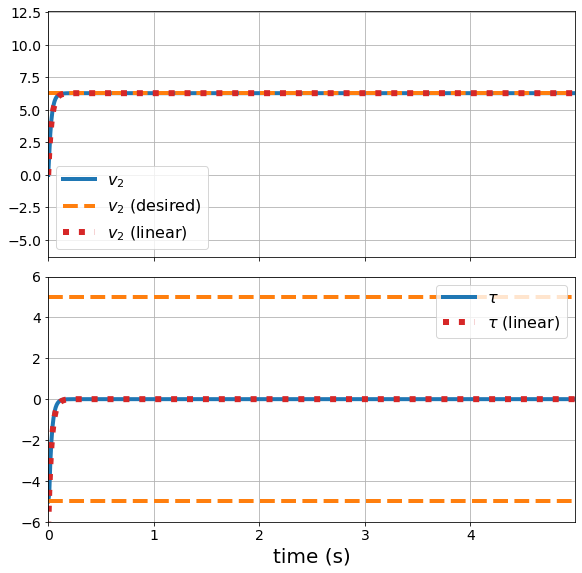

In [12]:
(v2i) = (0.)
data = get_data(simulator, v2e, taue, K, v2i, max_time=5.0)
show_results(data, v2e, taue, A, B, K, v2i, show_pred=True)

# Control platform angle only (no gravity)

Set ground roll angle of simulator.

In [13]:
simulator.set_roll(0.)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=0$, ignore wheel) are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

Define a function to return a state-space model for a given choice of equilibrium point.

In [14]:
def get_model(q1e, v1e, taue):
    # Define variables
    q1, v1, tau = sym.symbols('q1, v1, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1,
        (1 / J1) * tau,
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, tau], f)
    if not np.allclose(f_num(q1e, v1e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, tau], A_sym)
    B_num = sym.lambdify([q1, v1, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, v1e, taue).astype(float)
    B = B_num(q1e, v1e, taue).astype(float)

    # Return A and B
    return A, B

Define functions for implementation and analysis.

In [15]:
# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, q1e, v1e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, q1e, v1e, taue, K, q1i, v1i, max_time=5.0):
    # Create controller
    controller = Controller(K, q1e, v1e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=q1i,
        platform_velocity=v1i,
        wheel_angle=0.,
        wheel_velocity=0.,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, q1e, v1e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x

# Define a function to show results.
def show_results(data, q1e, v1e, taue, A, B, K, q1i, v1i, show_pred=False):
    t = data['t']
    q1 = data['platform_angle']
    v1 = data['platform_velocity']
    tau = - data['wheel_torque']
    x1 = q1 - q1e
    x2 = v1 - v1e
    
    fig, (ax_q1, ax_v1, ax_tau) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    ax_q1.plot(t, q1, label='$q_1$', linewidth=4)
    ax_q1.plot(t, np.ones_like(t) * q1e, '--', label='$q_1$ (desired)', linewidth=4)
    
    ax_v1.plot(t, v1, label='$v_1$', linewidth=4)
    ax_v1.plot(t, np.ones_like(t) * v1e, '--', label='$v_1$ (desired)', linewidth=4)
    
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
    ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, q1e, v1e, A, B)
        x1_num = x_num[:, 0]
        x2_num = x_num[:, 1]
        
        # Get u(t)
        u_num = - (K @ x_num.T).T
        u1_num = u_num[:, 0]
        
        # Compute q1(t) and v1(t) from x(t)
        q1_num = x1_num + q1e
        v1_num = x2_num + v1e
        
        # Compute tau(t) from u(t)
        tau_num = u1_num + taue
        
        # Add everything to plots
        ax_q1.plot(t, q1_num, ':', label='$q_1$ (linear)', linewidth=6, color='C3')
        ax_v1.plot(t, v1_num, ':', label='$v_1$ (linear)', linewidth=6, color='C3')
        ax_tau.plot(t, tau_num, ':', label=r'$\tau$ (linear)', linewidth=6, color='C3')
        
    ax_q1.grid()
    ax_q1.legend(fontsize=16)
    ax_q1.tick_params(labelsize=14)
    ax_q1.set_ylim(-1, 1)
    
    ax_v1.grid()
    ax_v1.legend(fontsize=16)
    ax_v1.tick_params(labelsize=14)
    ax_v1.set_ylim(-1, 1)

    ax_tau.grid()
    ax_tau.legend(fontsize=16)
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)
        
    ax_tau.set_xlabel('time (s)', fontsize=20)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Choose equilibrium point and get state-space model.

In [16]:
# Choose equilibrium point
(q1e, v1e, taue) = (np.pi / 6, 0., 0.)

# Get state-space model
A, B = get_model(q1e, v1e, taue)

# Show state-space model
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[0. 1.]
 [0. 0.]]

B =
[[0.]
 [1.]]


Check if system is controllable.

In [17]:
# Find controllability matrix
W = np.block([B, A @ B])

# Check size of controllability matrix
print(f'shape of W is {W.shape}\n')

# Find determinant of controllability matrix
print(f'det(W) = {linalg.det(W)}\n')

# Find rank of controllability matrix
print(f'rank(W) = {np.linalg.matrix_rank(W)}')
print(f'number of states is {A.shape[0]}')

shape of W is (2, 2)

det(W) = -1.0

rank(W) = 2
number of states is 2


Do control design by eigenvalue placement.

In [18]:
# Choose desired eigenvalue locations
p = [-1., -2.]

# Find gain matrix to put eigenvalues at desired locations
K = signal.place_poles(A, B, p).gain_matrix

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

K =
[[2. 3.]]

p = [-1.+0.j -2.+0.j]


Do control design by LQR.

In [25]:
# Choose weights
Q = np.diag([100., 1.])
R = np.diag([1.])


# Find optimal gain matrix (and cost matrix)
K, P = lqr(A, B, Q, R)

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

K =
[[10.          4.58257569]]

p = [-2.29128785+2.17944947j -2.29128785-2.17944947j]


Show results for particular choices of equilibrium point, gain matrix, and initial conditions.

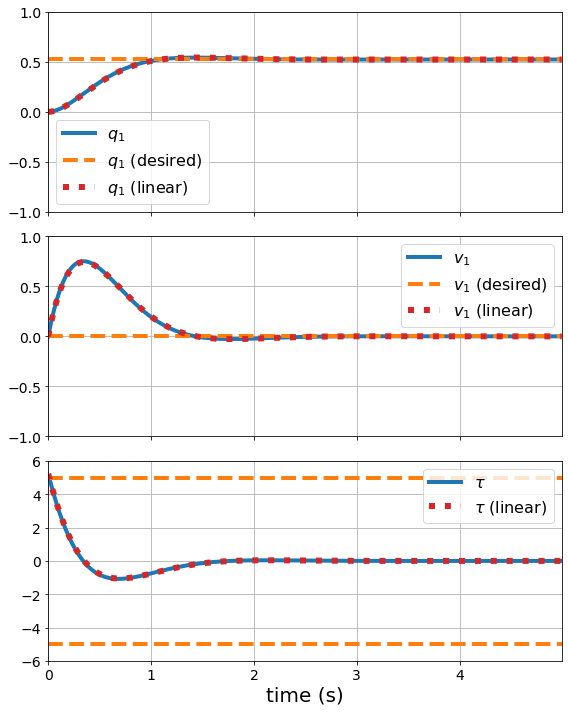

In [26]:
(q1i, v1i) = (0., 0.)
data = get_data(simulator, q1e, v1e, taue, K, q1i, v1i, max_time=5.0)
show_results(data, q1e, v1e, taue, A, B, K, q1i, v1i, show_pred=True)

# Control platform angle and wheel velocity with gravity

Set ground roll angle of simulator.

In [27]:
simulator.set_roll(np.pi / 2)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=\pi/2$) are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

Define a function to return a state-space model for a given choice of equilibrium point.

In [28]:
def get_model(q1e, v1e, v2e, taue):
    # Define variables
    q1, v1, v2, tau = sym.symbols('q1, v1, v2, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1,
        (1 / J1) * (tau - mw * g * l * sym.sin(q1)),
        (1 / J2) * (- ((J1 + J2) / J1) * tau + (J2 / J1) * mw * g * l * sym.sin(q1))
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, v2, tau], f)
    if not np.allclose(f_num(q1e, v1e, v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1, v2])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
    B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, v1e, v2e, taue).astype(float)
    B = B_num(q1e, v1e, v2e, taue).astype(float)

    # Return A and B
    return A, B

Define functions for implementation and analysis.

In [29]:
# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, q1e, v1e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0):
    # Create controller
    controller = Controller(K, q1e, v1e, v2e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=q1i,
        platform_velocity=v1i,
        wheel_angle=0.,
        wheel_velocity=v2i,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, q1e, v1e, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
        data['wheel_velocity'][0] - v2e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x
    
# Define a function to show results.
def show_results(data, q1e, v1e, v2e, taue, A, B, K, q1i, v1i, v2i, show_pred=False):
    t = data['t']
    q1 = data['platform_angle']
    v1 = data['platform_velocity']
    v2 = data['wheel_velocity']
    tau = - data['wheel_torque']
    x1 = q1 - q1e
    x2 = v1 - v1e
    x3 = v2 - v2e
    
    fig, (ax_q1, ax_v1, ax_v2, ax_tau) = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

    ax_q1.plot(t, q1, label='$q_1$', linewidth=4)
    ax_q1.plot(t, np.ones_like(t) * q1e, '--', label='$q_1$ (desired)', linewidth=4)
    
    ax_v1.plot(t, v1, label='$v_1$', linewidth=4)
    ax_v1.plot(t, np.ones_like(t) * v1e, '--', label='$v_1$ (desired)', linewidth=4)
    
    ax_v2.plot(t, v2, label='$v_2$', linewidth=4)
    ax_v2.plot(t, np.ones_like(t) * v2e, '--', label='$v_2$ (desired)', linewidth=4)
    
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
    ax_tau.plot(t, - simulator.tau_max * np.ones_like(t), '--', linewidth=4, color='C1')
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, q1e, v1e, v2e, A, B)
        x1_num = x_num[:, 0]
        x2_num = x_num[:, 1]
        x3_num = x_num[:, 2]
        
        # Get u(t)
        u_num = - (K @ x_num.T).T
        u1_num = u_num[:, 0]
        
        # Compute q1(t), v1(t), and v2(t) from x(t)
        q1_num = x1_num + q1e
        v1_num = x2_num + v1e
        v2_num = x3_num + v2e
        
        # Compute tau(t) from u(t)
        tau_num = u1_num + taue
        
        # Add everything to plots
        ax_q1.plot(t, q1_num, ':', label='$q_1$ (linear)', linewidth=6, color='C3')
        ax_v1.plot(t, v1_num, ':', label='$v_1$ (linear)', linewidth=6, color='C3')
        ax_v2.plot(t, v2_num, ':', label='$v_2$ (linear)', linewidth=6, color='C3')
        ax_tau.plot(t, tau_num, ':', label=r'$\tau$ (linear)', linewidth=6, color='C3')
        
    ax_q1.grid()
    ax_q1.legend(fontsize=16)
    ax_q1.tick_params(labelsize=14)
    ax_q1.set_ylim(np.pi - 0.5, np.pi + 0.5)
    
    ax_v1.grid()
    ax_v1.legend(fontsize=16)
    ax_v1.tick_params(labelsize=14)
    ax_v1.set_ylim(-1, 1)
    
    ax_v2.grid()
    ax_v2.legend(fontsize=16)
    ax_v2.tick_params(labelsize=14)
    ax_v2.set_ylim(-5, 5)

    ax_tau.grid()
    ax_tau.legend(fontsize=16)
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)
        
    ax_tau.set_xlabel('time (s)', fontsize=20)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Choose equilibrium point and get state-space model.

In [30]:
# Choose equilibrium point
(q1e, v1e, v2e, taue) = (np.pi, 0., 0., 0.)

# Get state-space model
A, B = get_model(q1e, v1e, v2e, taue)

# Show state-space model
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[ 0.      1.      0.    ]
 [ 2.4525  0.      0.    ]
 [-2.4525  0.      0.    ]]

B =
[[  0.]
 [  1.]
 [-33.]]


Check if system is controllable.

In [31]:
# Find controllability matrix
W = np.block([B, A @ B, A @ A @ B])

# Check size of controllability matrix
print(f'shape of W is {W.shape}\n')

# Find determinant of controllability matrix
print(f'det(W) = {linalg.det(W)}\n')

# Find rank of controllability matrix
print(f'rank(W) = {np.linalg.matrix_rank(W)}')
print(f'number of states is {A.shape[0]}')

shape of W is (3, 3)

det(W) = -78.48

rank(W) = 3
number of states is 3


Do control design by eigenvalue placement.

In [32]:
# Choose desired eigenvalue locations
p = [-1., -2., -3.]

# Find gain matrix to put eigenvalues at desired locations
K = signal.place_poles(A, B, p).gain_matrix

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

K =
[[13.4525      8.52293578  0.0764526 ]]

p = [-3.+0.j -2.+0.j -1.+0.j]


Do control design by LQR.

In [33]:
# Choose weights
Q = np.diag([1., 1., 1.])
R = np.diag([1.])

# Find optimal gain matrix (and cost matrix)
K, P = lqr(A, B, Q, R)

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

K =
[[106.63052913  69.10070717   1.        ]]

p = [-33.01745617+0.j          -1.5416255 +0.01775691j
  -1.5416255 -0.01775691j]


Show results for particular choices of equilibrium point, gain matrix, and initial conditions.

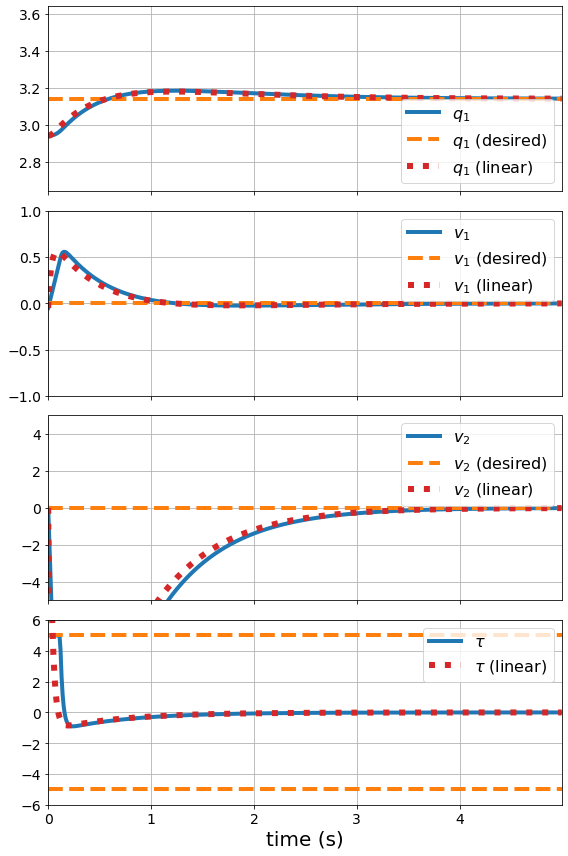

In [35]:
(q1i, v1i, v2i) = (np.pi - 0.2, -0.05, 0.)
data = get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0)
show_results(data, q1e, v1e, v2e, taue, A, B, K, q1i, v1i, v2i, show_pred=True)

# Control platform angle and wheel velocity *without* gravity

Set ground roll angle of simulator.

In [ ]:
simulator.set_roll(0.)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=0$) are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

Define a function to return a state-space model for a given choice of equilibrium point.

In [ ]:
def get_model(q1e, v1e, v2e, taue):
    # Define variables
    q1, v1, v2, tau = sym.symbols('q1, v1, v2, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1,
        (1 / J1) * (tau),
        (1 / J2) * (- ((J1 + J2) / J1) * tau)
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, v2, tau], f)
    if not np.allclose(f_num(q1e, v1e, v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1, v2])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
    B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, v1e, v2e, taue).astype(float)
    B = B_num(q1e, v1e, v2e, taue).astype(float)

    # Return A and B
    return A, B

Choose equilibrium point and get state-space model.

In [ ]:
# Choose equilibrium point
(q1e, v1e, v2e, taue) = (np.pi, 0., 0., 0.)

# Get state-space model
A, B = get_model(q1e, v1e, v2e, taue)

# Show state-space model
print(f'A =\n{A}\n\nB =\n{B}')

Check if system is controllable.

In [ ]:
# Find controllability matrix
W = np.block([B, A @ B, A @ A @ B])

# Check size of controllability matrix
print(f'shape of W is {W.shape}\n')

# Find determinant of controllability matrix
print(f'det(W) = {linalg.det(W)}\n')

# Find rank of controllability matrix
print(f'rank(W) = {np.linalg.matrix_rank(W)}')
print(f'number of states is {A.shape[0]}')

Do control design by eigenvalue placement.

In [ ]:
# Choose desired eigenvalue locations
p = [-1., -2., -3.]

# Find gain matrix to put eigenvalues at desired locations
K = signal.place_poles(A, B, p).gain_matrix

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

Do control design by LQR.

In [ ]:
# Choose weights
# Q = ... # <-- FIXME
# R = ... # <-- FIXME

# Find optimal gain matrix (and cost matrix)
K, P = lqr(A, B, Q, R)

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

#### What if $A$ was very, very slightly different?

In [ ]:
A2 = A + 1e-8 * np.random.standard_normal(size=A.shape)

print(f'A =\n{A}\n')
print(f'A2 =\n{A2}')

Check if system is controllable.

In [ ]:
# Find controllability matrix
W = np.block([B, A2 @ B, A2 @ A2 @ B])

# Check size of controllability matrix
print(f'shape of W is {W.shape}\n')

# Find determinant of controllability matrix
print(f'det(W) = {linalg.det(W)}\n')

# Find rank of controllability matrix
print(f'rank(W) = {np.linalg.matrix_rank(W)}')
print(f'number of states is {A.shape[0]}')

Do eigenvalue placement.

In [ ]:
# Choose desired eigenvalue locations
p = [-1., -2., -3.]

# Find gain matrix to put eigenvalues at desired locations
K = signal.place_poles(A2, B, p).gain_matrix

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A2 - B @ K)}')

Check singular values and condition number of $W$ instead of determinant and rank.

In [ ]:
print(f'singular values of W: {linalg.svdvals(W)}')

In [ ]:
print(f'condition number of W: {np.linalg.cond(W)}')

In [ ]:
s = linalg.svdvals(W)
ratio = max(s) / min(s)
print(f'ratio of largest singular value to smallest singlar value of W: {ratio}')

Do control design by LQR.

In [ ]:
# Choose weights
# Q = ... # <-- FIXME
# R = ... # <-- FIXME

# Find optimal gain matrix (and cost matrix)
K, P = lqr(A, B, Q, R)

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

#### If a system is not controllable, does that mean we are completely out of luck?

In [ ]:
K = np.array([[1., 2., 3.]])

print(linalg.eigvals(A - B @ K))

In [ ]:
K = np.array([[11., 12., 13.]])

print(linalg.eigvals(A - B @ K))

# Control platform angle with *two* reaction wheels

In [ ]:
# Get state-space model
A = np.array([[0., 1.], [0., 0.]])
B = np.array([[0., 0.], [1., 10.]])

# Show state-space model
print(f'A =\n{A}\n\nB =\n{B}')

Check if system is controllable.

In [ ]:
# Find controllability matrix
W = np.block([B, A @ B])

# Check size of controllability matrix
print(f'shape of W is {W.shape}\n')

# # Find determinant of controllability matrix
# print(f'det(W) = {linalg.det(W)}\n')

# Find rank of controllability matrix
print(f'rank(W) = {np.linalg.matrix_rank(W)}')
print(f'number of states is {A.shape[0]}')

Choose linear combination of inputs.

In [ ]:
# First column of B
B_col1 = B[:, 0:1]

# Second column of B
B_col2 = B[:, 1:2]

# Multipliers
m1 = 0.1
m2 = 0.9

# Linear combination
B1 = m1 * B_col1 + m2 * B_col2

print(f'B1 =\n{B1}')

Do eigenvalue placement.

In [ ]:
# Choose desired eigenvalue locations
p = [-1., -2.]

# Find gain matrix to put eigenvalues at desired locations
K1 = signal.place_poles(A, B1, p).gain_matrix

# Find gain matrix for original system
K = np.block([[m1 * K1], [m2 * K1]])

# Show gain matrix
print(f'K =\n{K}\n')

# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

Could we have done eigenvalue placement with `place_poles` all at once?

In [ ]:
# Choose desired eigenvalue locations
p = [-1., -2.]

# Find gain matrix to put eigenvalues at desired locations
K = signal.place_poles(A, B, p).gain_matrix